# Lab2 使用Sobel算子提取Lena的边缘
# 01：OpenCV Sobel

## 检查Lena的图片 
我们首先导入OpenCV-Python库用作图像处理（Sobel），matplotlib库用作绘图。

In [63]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

我们可以通过`imread`方法读取jpg格式的图片，原图是一张400x400大小的三通道的图片。

In [64]:
img = cv2.imread("./lena.jpg")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(400, 400, 3)


通过`imshow`方法进行图片显示。

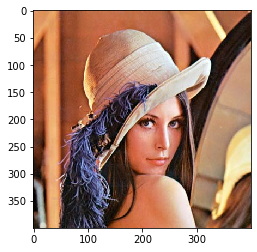

In [65]:
plt.imshow(img[:,:,::-1])

### RGB图转灰度图
将RGB图像转为灰度图，我们可以直观的看到数据维度的变化。

In [66]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(400, 400)


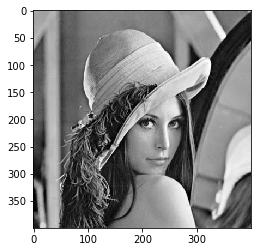

In [67]:
plt.imshow(gray,cmap='gray')

### 使用Sobel算子提取边缘
我们可以使用`Sobel`方法对图像提取边缘，最后两个参数表示导数x与y的阶数。
- `sobel_x`与`sobel_y`为横向与纵向上的边缘检测结果
- `sobel_res`为两者相加得到的梯度，并在0-255之间截断，即我们得到的结果

In [68]:
import time

start_time = time.time()

sobel_x =cv2.Sobel(gray,cv2.CV_8U ,1,0)
sobel_y = cv2.Sobel(gray,cv2.CV_8U ,0,1)
sobel_res = np.clip(sobel_x + sobel_y, 0, 255)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.03149151802062988s


绘制上述三幅图像。

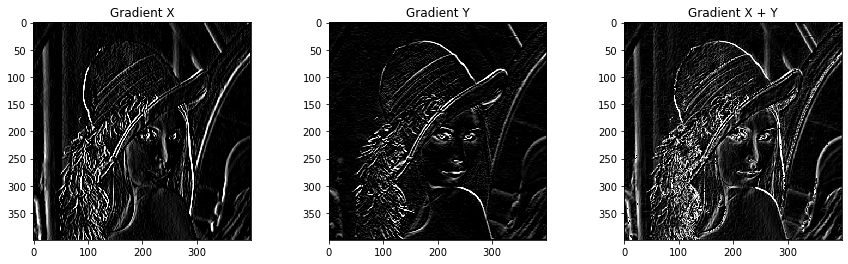

In [69]:
fig_sobel3 = plt.figure()
fig_sobel3.set_figheight(4)
fig_sobel3.set_figwidth(15)
# gradient x
fig_1 = fig_sobel3.add_subplot(131)
fig_1.title.set_text('Gradient X')
plt.imshow(sobel_x,cmap='gray')
# gradient y
fig_2 = fig_sobel3.add_subplot(132)
fig_2.title.set_text('Gradient Y')
plt.imshow(sobel_y,cmap='gray')
# gradient
fig_3 = fig_sobel3.add_subplot(133)
fig_3.title.set_text('Gradient X + Y')
plt.imshow(sobel_res,cmap='gray')

# 02:  Hardware Sobel
## 方式1：直接调用
我们会在方式1中展示类似Lab1的直接调用方式，在方式2中将通过创建Driver来构建一个用户友好的API。
### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [70]:
from pynq import Overlay, allocate

overlay = Overlay("./overlay_axis/sobel.bit")

sobel = overlay.sobel_0

In [71]:
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

### 写入参数
在IP上写入值时，我们可以像Lab1一样根据HLS给出的IP Driver Source Code直接在对应位置写入：

In [72]:
sobel.write(0x10, rows)
sobel.write(0x18, cols)

由于提供了`Sobel.hwh`文件，`sobel`对象已经包含了Register Map并将其暴露出来，我们可以直接打印查看各寄存器的信息：

In [73]:
sobel.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [74]:
sobel.register_map.rows = rows
sobel.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [75]:
dma = overlay.axi_dma_0

Sobel IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [76]:
import time

sobel.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.011716842651367188s


将结果进行可视化。

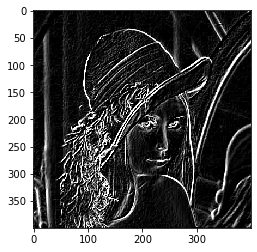

In [77]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

## 方式2：为IP创建一个Driver
创建一个用户有好的API将是我们的下一步，我们希望可以创建一个对于特定IP的驱动程序。
- 公开单个的`sobel3x3`函数来调用加速器
- 继承pynq的`DeafaultIP`

In [78]:
from pynq import DefaultIP

class SobelDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:sobel:1.0']

    def sobel3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

重新载入Overlay使得更改生效：

In [79]:
overlay = Overlay("./overlay_axis/sobel.bit")
dma = overlay.axi_dma_0
sobel = overlay.sobel_0

现在，我们可以直接调用上方描述的`sobel3x3`方法：

In [80]:
res = sobel.sobel3x3(input_buffer, output_buffer, rows, cols)

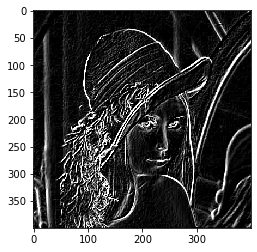

In [81]:
plt.imshow(res,cmap='gray')